In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from keras.api.optimizers import Adam
from keras import layers, models, utils, losses
import keras
import random
from keras.api.utils import image_dataset_from_directory
from PIL import Image
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-12-15 17:34:11.847874: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 17:34:11.856790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734280451.866364  155651 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734280451.869247  155651 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 17:34:11.879878: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [40]:
class CustomDataGen(keras.utils.Sequence):
    def __init__(self, data_folder: str, aug_len: dict[str, float], batch_size=32, split="train", train_ratio=0.8, seed=42):
        super().__init__()

        self.data_folder = data_folder
        self.aug_len = aug_len
        self.batch_size = batch_size
        self.data = []

        self.pipeline = tf.keras.Sequential([
            keras.layers.RandomFlip("horizontal_and_vertical"),
            keras.layers.RandomRotation(0.2),
            keras.layers.RandomZoom(0.1),
            keras.layers.RandomContrast(0.01),
            keras.layers.Rescaling(1./255),
            keras.layers.Resizing(224, 224),
            keras.layers.Normalization(
                mean=(0.485, 0.456, 0.406), 
                variance=(0.229, 0.224, 0.225)
            )
        ])

        self.split = split
        self.train_ratio = train_ratio
        self.seed = seed
        self.load_data()
        
        self.classes = {label: idx for idx, label in enumerate(set([item["label"] for item in self.data]))}
        print(self.classes)

    
    def load_data(self):
        all_files = []
        for root, _, files in os.walk(self.data_folder):
            ext = os.path.splitext(files[0])[1]
            if ext not in [".jpg", ".jpeg", ".png"]:
                continue
            subfolder = os.path.basename(root)
            for file in files:
                all_files.append({
                    "path": os.path.join(root, file),
                    "label": subfolder
                })
    
        random.seed(self.seed)
        random.shuffle(all_files)
    
        # Ensure all labels are present in both splits
        label_counts = {label: 0 for label in set([item["label"] for item in all_files])}
        for item in all_files:
            label_counts[item["label"]] += 1
    
        train_files = []
        test_files = []
        for label, count in label_counts.items():
            label_files = [item for item in all_files if item["label"] == label]
            split_idx = int(count * self.train_ratio)
            train_files.extend(label_files[:split_idx])
            test_files.extend(label_files[split_idx:])
    
        if self.split == "train":
            base_files = train_files
        else:
            base_files = test_files
    
        self.data = []
        for file in base_files:
            if self.split == "train" and file["label"] in self.aug_len:
                prob = self.aug_len[file["label"]]
                for _ in range(int(prob)):
                    self.data.append(file)
                if np.random.rand() < (prob - int(prob)):
                    self.data.append(file)
            else:
                self.data.append(file)
    
        random.shuffle(self.data)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []
        for item in batch_data:
            img = Image.open(item["path"])
            img = np.array(img)
            if img.ndim == 2:
                img = np.stack((img,) * 3, axis=-1)
            elif img.shape[2] == 1:
                img = np.concatenate([img] * 3, axis=-1)
            img = self.pipeline(img)
            batch_images.append(img)
            batch_labels.append(self.classes[item["label"]])

        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        random.shuffle(self.data)

In [41]:
# Data Set
train = CustomDataGen("/home/shared/Mammiferes_jpg", {"cat": 1.5, "dog": 1.5}, batch_size=8, split="train")
test = CustomDataGen("/home/shared/Mammiferes_jpg", {"cat": 1.5, "dog": 1.5}, batch_size=8, split="test")

{'Loup': 0, 'Coyote': 1, 'Ours': 2, 'Chien': 3, 'Lynx': 4, 'Lapin': 5, 'Renard': 6, 'Raton_laveur': 7, 'Rat': 8, 'Chat': 9, 'Ecureuil': 10, 'Puma': 11, 'Castor': 12}
{'Coyote': 0, 'Loup': 1, 'Ours': 2, 'Chat': 3, 'Chien': 4, 'Lynx': 5, 'Lapin': 6, 'Renard': 7, 'Raton_laveur': 8, 'Rat': 9, 'Puma': 10, 'Ecureuil': 11, 'Castor': 12}


In [42]:
# Modele
model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(13, activation='softmax')
])

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses.sparse_categorical_crossentropy,
    metrics= ["accuracy"]
)

In [44]:
history = model.fit(
    train,
    batch_size=8,
    validation_data=test,
    epochs=20
)

Epoch 1/20


I0000 00:00:1734282591.280354  156761 service.cc:148] XLA service 0xceaaf90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734282591.280479  156761 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-12-15 18:09:51.300313: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734282591.392685  156761 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-15 18:09:51.505008: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.0347 - loss: 3.0588 

I0000 00:00:1734282592.827378  156761 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.0605 - loss: 3.2135 - val_accuracy: 0.0357 - val_loss: 2.7653
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.1364 - loss: 2.5455 - val_accuracy: 0.1071 - val_loss: 2.6459
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.0703 - loss: 2.5359 - val_accuracy: 0.0893 - val_loss: 2.6183
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.1041 - loss: 2.5056 - val_accuracy: 0.0536 - val_loss: 2.6463
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.1093 - loss: 2.5265 - val_accuracy: 0.0893 - val_loss: 2.6191
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.1274 - loss: 2.4937 - val_accuracy: 0.0893 - val_loss: 2.6284
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.1060 - loss: 2.5153 - val_accuracy: 0.1071 - val_loss: 2.6834
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.1127 - loss: 2.5016 - val_accuracy: 0.1071 - val_

/tmp/ipykernel_155651/878362657.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


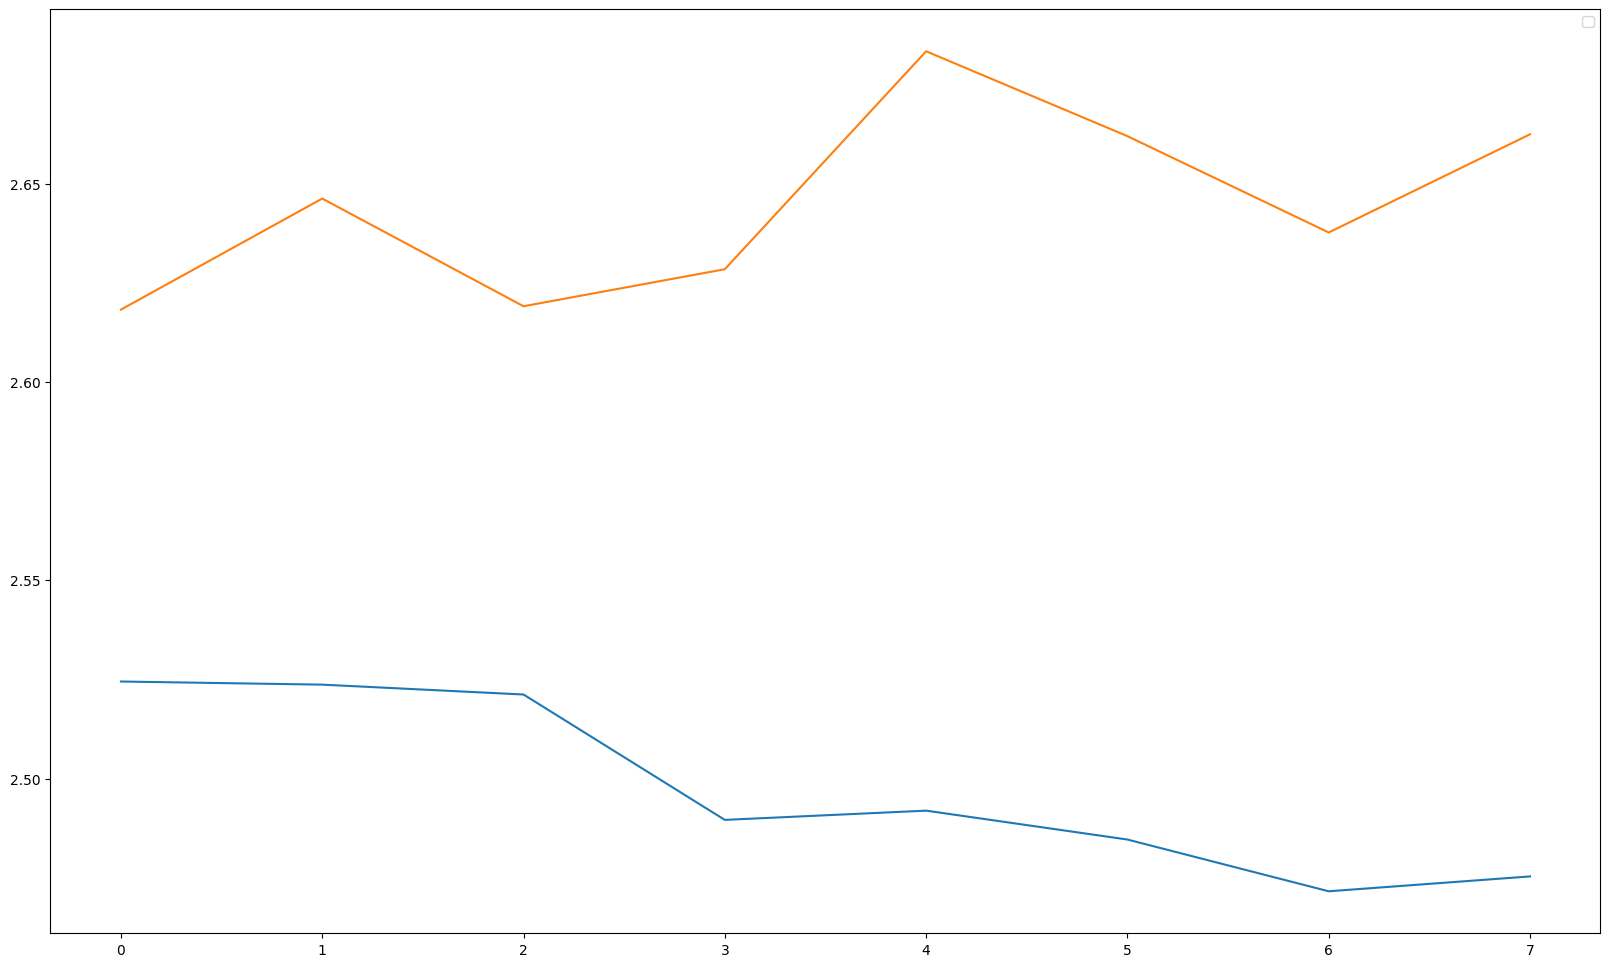

In [45]:
plt.figure(figsize=(20,12))
plt.plot(history.history["loss"][2:10])
plt.plot(history.history["val_loss"][2:10])
plt.legend()

In [46]:
plt.imshow(Image.open("/home/shared/Mammiferes/Castor/original.jpeg"))

FileNotFoundError: [Errno 2] No such file or directory: '/home/shared/Mammiferes/Castor/original.jpeg'

In [47]:
castor = tf.io.read_file("/home/shared/Mammiferes/Castor/original.jpeg")
castor = tf.image.decode_jpeg(castor, channels=3)
resized_castor = tf.image.resize(castor, [256,256], method="bilinear")

2024-12-15 18:12:08.768267: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: /home/shared/Mammiferes/Castor/original.jpeg; No such file or directory
2024-12-15 18:12:08.768286: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: NOT_FOUND: /home/shared/Mammiferes/Castor/original.jpeg; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /home/shared/Mammiferes/Castor/original.jpeg; No such file or directory [Op:ReadFile]

In [48]:
input = tf.expand_dims(
    resized_castor,
    axis = 0
)

NameError: name 'resized_castor' is not defined

In [49]:
input.shape

AttributeError: 'function' object has no attribute 'shape'

In [50]:
model.predict(input)

ValueError: Unrecognized data type: x=<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x79e4eb38d9d0>> (of type <class 'method'>)

In [51]:
next(iter(test))[0].shape

(8, 224, 224, 3)

In [52]:
class_names = train.class_names
print(class_names)

AttributeError: 'CustomDataGen' object has no attribute 'class_names'

In [53]:
plt.figure(figsize=(10, 10))
batch,_ = test.take(3)
image_to_test = batch[0][1].numpy().astype("uint8")
plt.imshow(image_to_test)
plt.title(class_names[batch[1][1]])
plt.axis("off")

AttributeError: 'CustomDataGen' object has no attribute 'take'

<Figure size 1000x1000 with 0 Axes>

In [54]:
input_to_test = tf.expand_dims(
    image_to_test,
    axis = 0
)

NameError: name 'image_to_test' is not defined

In [55]:
model.predict(input_to_test)

NameError: name 'input_to_test' is not defined

In [56]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: 'CustomDataGen' object has no attribute 'take'

<Figure size 1000x1000 with 0 Axes>